Compared to design2_v1, this version has better file handling steps. This version will save the data during optimization so that the optimization can be retrieved and continued even if it's interrupted.

In [1]:
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library, Medium, Structure

import autograd
from autograd.tracer import getval
import autograd.numpy as anp
import autograd.scipy.stats as stat
from autograd.scipy.special import erfinv, erf
from typing import List, Tuple

import matplotlib.pylab as plt
import numpy as np
import os
import optax

## Create Simulation Structures

### Define basic simulation parameters

Most custom parameters are defined in the following block. However, the `param_to_design_info` needs to be carefully reviewed if the structure has changes in the layer numbers and dielectric/metal combinations as it is tightly bound to a specific structure.

In [2]:
Ni = material_library["Ni"]["RakicLorentzDrude1998"]  # Valid for 0.25 - 6.2 um
SiO2 = Medium(permittivity=2.08, name="SiO2")

bandwidth = 0.25  # microns
wvl_range = [3.30, 5.20]  # microns
freq_range = [td.C_0 / wvl_range[1], td.C_0 / wvl_range[0]]
wvls = np.linspace(wvl_range[0], wvl_range[1], 101)

wvl0 = np.mean(wvl_range)
freq0 = td.C_0 / wvl0

print(f"Center frequency:\t{freq0: .2e} Hz")
print(f"Center wavelength:\t{wvl0} um")
print(f"Target bandwidth:\t{bandwidth} um")
print(f"Frequency range:\t[{freq_range[0]: .2e}, {freq_range[1]: .2e}] Hz")
print(f"Wavelength range:\t{wvl_range} um")

fwidth = td.constants.C_0 / wvl_range[0] - td.constants.C_0 / wvl_range[1]
run_time = 300 / fwidth
shutoff = 1e-4

print(f"\nSource frequency width:\t{fwidth: .2e} Hz")
print(f"Run time:\t\t{run_time: .2e} s")
print(f"Shutoff:\t\t{shutoff: .2e} W/m^2")

# monitor_wvls = np.array([3.3, 3.395, 3.604, 3.794, 3.90, 3.95, 4.098, 4.15, 4.25, 4.32, 4.402, 4.497, 4.592, 4.706, 4.801, 4.953])
# monitor_freqs = np.flip(td.constants.C_0 / monitor_wvls)
# wvl_points = len(monitor_wvls)

# print(f"\nMonitor frequency range: [{monitor_freqs[0]: .2e}, {monitor_freqs[-1]: .2e}] Hz")

monitor_wvls = []
monitor_freqs = []
target_adaptive = []
peak_wvl = wvl0
wvl_points = 17

buffer_size = 0.1  # distance between the source and the monitor
distance = wvl0  # distance between the source/monitor/structure and the PML

# Define the structure constraints
# Default substrate values
sub_metal_thickness = 0.2
sub_dielectric_thickness = 0.25
num_of_sub_layers = 2
# Substrate constraints
sub_metal_min_thickness = 0.1
sub_metal_max_thickness = 0.3
sub_dielectric_min_thickness = 0.15
sub_dielectric_max_thickness = 0.35
sub_thickness_constraints_min = [sub_metal_min_thickness, sub_dielectric_min_thickness]
sub_thickness_constraints_max = [sub_metal_max_thickness, sub_dielectric_max_thickness]

# Default cuboid values
cuboid_metal_thickneness = 0.025
cuboid_dielectric_thickness = 0.1
num_of_cuboid_layers = 2 * 5  # 5 bilayers
# Cuboid constraints
cuboid_min_length = 1.0
cuboid_max_length = 3.4
cuboid_min_width = 1.0
cuboid_max_width = 3.4
cuboid_metal_min_thickness = 0.015
cuboid_metal_max_thickness = 0.035
cuboid_dielectric_min_thickness = 0.05
cuboid_dielectric_max_thickness = 0.2
cuboid_thickness_constraints_min = [
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
]
cuboid_thickness_constraints_max = [
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
]

sub_materials = [Ni, SiO2]
cuboid_materials = [Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2]

# Simulation domain
Lx = 3.5
Ly = 3.5
Lz = (
    2 * wvl0
    + buffer_size
    + distance
    + sub_metal_max_thickness
    + sub_dielectric_max_thickness
    + 5 * (cuboid_metal_max_thickness + cuboid_dielectric_max_thickness)
)
min_steps_per_wvl = 10  # outside of structure
# fine discretization in propagation direction
# make sure to double-check discretization in xy
override_dl = (0.1, 0.1, 0.005)

Center frequency:	 7.05e+13 Hz
Center wavelength:	4.25 um
Target bandwidth:	0.25 um
Frequency range:	[ 5.77e+13,  9.08e+13] Hz
Wavelength range:	[3.3, 5.2] um

Source frequency width:	 3.32e+13 Hz
Run time:		 9.04e-12 s
Shutoff:		 1.00e-04 W/m^2


### Define source and monitor objects

In [3]:
SOURCE_PLANEWV_NAME = "source_planewave"
FLUX_MONITOR_NAME = "monitor_flux"

source_planewave = td.PlaneWave(
    center=(0, 0, Lz / 2 - wvl0 - buffer_size),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    direction="-",
    pol_angle=0,
    name=SOURCE_PLANEWV_NAME,
)

### Function to create the structure

Parameter frame structure: 

| substrate thicknesses from bottom up | cuboid thicknesses from bottom up | cuboid length | cuboid width |
| --- | --- | --- | --- |

Every data frame is a NumPy array, which then form a Tuple.

In [4]:
def make_dynamic_structures(design_info: Tuple) -> List[Structure]:
    if design_info is None:
        return []

    sub_thicknesses, cuboid_thicknesses, cuboid_length, cuboid_width = design_info
    sub_thicknesses = anp.clip(sub_thicknesses, sub_thickness_constraints_min, sub_thickness_constraints_max)
    cuboid_thicknesses = anp.clip(cuboid_thicknesses, cuboid_thickness_constraints_min, cuboid_thickness_constraints_max)
    cuboid_length = anp.clip(cuboid_length, cuboid_min_length, cuboid_max_length)
    cuboid_width = anp.clip(cuboid_width, cuboid_min_width, cuboid_max_width)

    # Substrate
    substrate = []
    z_center = -Lz / 2 + distance
    for i in range(num_of_sub_layers):
        z_center = z_center + sub_thicknesses[i] / 2 + (sub_thicknesses[i - 1] / 2 if i > 0 else 0)

        substrate.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(td.inf, td.inf, sub_thicknesses[i]),
                ),
                medium=sub_materials[i],
            )
        )

    z_center = z_center + sub_thicknesses[-1] / 2

    # Cuboid
    cuboid = []
    for i in range(num_of_cuboid_layers):
        z_center = (
            z_center + cuboid_thicknesses[i] / 2 + (cuboid_thicknesses[i - 1] / 2 if i > 0 else 0)
        )

        cuboid.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(cuboid_length[0], cuboid_width[0], cuboid_thicknesses[i]),
                ),
                medium=cuboid_materials[i],
            )
        )

    return substrate + cuboid

### Function to create the simulation object

In [5]:
def make_sim(design_info: Tuple) -> td.Simulation:
    boundary_spec = td.BoundarySpec(
        x=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        y=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        z=td.Boundary(minus=td.PML(), plus=td.PML()),
    )

    dynamic_structures = make_dynamic_structures(design_info)

    # make mesh override, zmin and zmax are the bounds of the structure rounded down/up to the nearest 0.1
    zmin = np.floor(getval(dynamic_structures[0].geometry.bounds[0][2]) * 10) / 10
    zmax = np.ceil(getval(dynamic_structures[-1].geometry.bounds[1][2]) * 10) / 10
    override = td.MeshOverrideStructure(
        geometry=td.Box.from_bounds((-1e3, -1e3, zmin), (1e3, 1e3, zmax)),
        dl=override_dl,
        enforce=True,
    )

    grid_spec = td.GridSpec.auto(
        wavelength=min(wvl_range),  # always mesh for smallest wavelength
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=[override],
    )

    sim = td.Simulation(
        center=(0, 0, 0),
        size=(Lx, Ly, Lz),
        run_time=run_time,
        boundary_spec=boundary_spec,
        grid_spec=grid_spec,
        structures=dynamic_structures,
        sources=[source_planewave],
        monitors=[],  # will be added in objective function
        shutoff=shutoff,
        symmetry=(-1, 1, 0),
    )

    return sim

### Check point

In [6]:
def get_spectrum(time: np.array, data: np.array) -> np.array:
    fs = 1 / (time[1] - time[0])
    n = len(data)

    signal_fft = np.fft.fft(data)
    freqs = np.fft.fftfreq(n, 1 / fs)
    spectrum = np.abs(signal_fft)

    # Filter out small values
    threshold = np.max(spectrum) * 1e-3  # 0.1% of the maximum value
    spectrum[spectrum < threshold] = 0

    return freqs, spectrum

Values of random_design_info: (array([0.18719898, 0.10518525]), array([0.02599325, 0.02370645, 0.02340736, 0.0216067 , 0.01909297,
       0.02738542, 0.02099309, 0.02033655, 0.02742268, 0.02558284]), array([1.32299187]), array([2.23258749]))


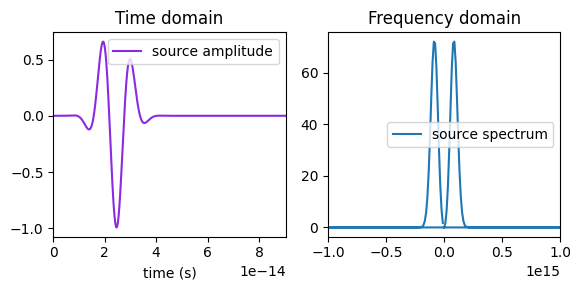

21:08:06 BST Created task 'week08_design_credit_estimation' with task_id        
             'fdve-26889468-ce3b-4d04-ad34-3994eaffd71e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=666127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26889468-ce3b-4d04-ad34-3994eaffd71e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=302783;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26889468-ce3b-4d04-ad34-3994eaffd71e\taskId]8;;\]8;id=666127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26889468-ce3b-4d04-ad34-3994eaffd71e\=]8;;\]8;id=189141;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26889468-ce3b-4d04-ad34-3994eaffd71e\fdve]8;;\]8;id=666127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26889468-ce3b-4d04-ad34-3994eaffd71e\-26889468-ce3]8;;\
             ]8;id=666127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26889468-ce3b-4d04-ad34-3994eaffd71e\b-4d04-ad34-3994eaffd71e']8;;\.

Output()

21:08:08 BST Maximum FlexCredit cost: 0.038. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Estimated cost: 0.03767501839801318


In [7]:
anp.random.seed(2)

random_sub_thicknesses = anp.random.uniform(
    sub_metal_min_thickness, sub_metal_max_thickness, num_of_sub_layers
)
random_cuboid_thicknesses = anp.random.uniform(
    cuboid_metal_min_thickness, cuboid_metal_max_thickness, num_of_cuboid_layers
)
random_cuboid_length = anp.random.uniform(cuboid_min_length, cuboid_max_length, 1)
random_cuboid_width = anp.random.uniform(cuboid_min_width, cuboid_max_width, 1)

random_design_info = (
    random_sub_thicknesses,
    random_cuboid_thicknesses,
    random_cuboid_length,
    random_cuboid_width,
)

print(f"Values of random_design_info: {random_design_info}")

random_sim = make_sim(random_design_info)

# Plot the source signal in time and frequency domain
times = np.arange(0, random_sim.run_time, random_sim.dt)
amplitudes = np.real(random_sim.sources[0].source_time.amp_time(times))

(fig, (ax_time, ax_freq)) = plt.subplots(1, 2, tight_layout=True, figsize=(6, 3))
ax_time = random_sim.sources[0].source_time.plot(
    times=np.linspace(0, random_sim.run_time / 100, 1001), ax=ax_time
)
ax_time.set_title("Time domain")
ax_time.set_xlim(0, random_sim.run_time / 100)
ax_time.legend(["source amplitude"])

line = ax_time.lines[0]
x_data = line.get_xdata()
y_data = line.get_ydata()

freqs, spectrum = get_spectrum(x_data, y_data)
ax_freq.plot(freqs, spectrum)
ax_freq.set_title("Frequency domain")
ax_freq.set_xlim(-1e15, 1e15)
ax_freq.legend(["source spectrum", "measurement"])

plt.show()

# 3D plot of the random design
# random_sim.plot_3d()
# plt.show()

# Cost estimation for each simulation
job_random_sim = td.web.Job(
    simulation=random_sim, task_name="week08_design_credit_estimation", verbose=True
)
estimated_cost = td.web.estimate_cost(job_random_sim.task_id)
print(f"Estimated cost: {estimated_cost}")

## Objective Function

### Define the target and evaluate error

This block is for fixed target definition and evaluation.

In [8]:
def target_square() -> anp.array:
    wvl_min = wvl0 - bandwidth / 2.0
    wvl_max = wvl0 + bandwidth / 2.0
    print(f"wvl_min: {wvl_min: .2f}, wvl_max: {wvl_max: .2f}")
    return (wvls >= wvl_min) & (wvls <= wvl_max)

def target_gaussian(mu: float=wvl0, peak_value: float=1.0, sigma: float=bandwidth/2.0) -> anp.array:
    target = peak_value * anp.exp(-((monitor_wvls - mu) ** 2) / (2 * sigma ** 2))
    target = 1 - target
    print(f"\tGaussian target:\n\t\tPeak value: {peak_value:.2f}, mu: {mu:.2f}, sigma: {sigma:.2f}")
    print(f"\t\twvl_min: {mu - 2*sigma:.2f}, wvl_max: {mu + 2*sigma:.2f}")
    return target

def plot_gaussian_and_flux_info(wvls, target, flux): 
    # Plot target and flux
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes = axes.flatten()

    axes[0].scatter(wvls, target, marker='o', color='#6AA121')
    axes[0].set_title(f"Target")
    axes[0].set_xlabel("Wavelength (um)")
    axes[0].set_ylabel("Reflectance")
    axes[0].grid(True)

    axes[1].scatter(wvls, flux, marker='o', color='#6AA121')
    axes[1].set_title(f"Actual flux")
    axes[1].set_xlabel("Wavelength (um)")
    axes[1].set_ylabel("Reflectance")
    axes[1].grid(True)

    plt.xlim(wvl_range[0], wvl_range[1])
    plt.tight_layout()
    plt.show()

def evaluate_flux_error_MAE(flux: anp.array) -> float:
    target = target_gaussian()
    error = anp.sum(anp.abs(flux - target)) / wvl_points
    return error

def evaluate_flux_error_MSE(flux: anp.array) -> float:
    diff2 = anp.abs(flux - target_gaussian()) ** 2
    error = anp.sum(diff2) / wvl_points
    return error

def evaluate_flux_error_weighted_MAE(flux: anp.array) -> float:
    target = target_gaussian()
    print(f"Target: {target}")
    weights = 1 / (target + 1)
    error = anp.sum(weights * anp.abs(flux - target)) / wvl_points

    flux_detraced = np.array([data._value for data in flux])

    plot_gaussian_and_flux_info(monitor_wvls, target, flux_detraced)

    return error

This block is for adaptive target definition and evaluation.

In [9]:
def find_peak_from_flux(flux: anp.array):
    min_index = anp.argmin(flux)
    return monitor_wvls[min_index]

def generate_sample_wvls_denser_center(center) -> anp.array:
    # v1 has denser points around the center
    std_dev = 0.4

    upper_bound = 0.5 * (1 + erf((wvl_range[1] - center) / (anp.sqrt(2) * std_dev)))
    lower_bound = 0.5 * (1 + erf((wvl_range[0] - center) / (anp.sqrt(2) * std_dev)))

    uniform_wvls = anp.linspace(lower_bound, upper_bound, wvl_points)
    gaussian_wvls = center + std_dev * anp.sqrt(2) * erfinv(2 * uniform_wvls - 1)
    
    return gaussian_wvls

def generate_sample_wvls_denser_edges(center) -> anp.array:
    # v2 has denser points at edges
    std_dev = 0.05

    cdf_min = wvl_range[0] * 0.9
    cdf_max = wvl_range[1] * 1.1

    coeff1 = cdf_max - cdf_min
    coeff2 = cdf_min

    upper_bound = erfinv(2 * (wvl_range[1] - coeff2) / coeff1 - 1) * anp.sqrt(2) * std_dev + center
    lower_bound = erfinv(2 * (wvl_range[0] - coeff2) / coeff1 - 1) * anp.sqrt(2) * std_dev + center

    uniform_wvls = anp.linspace(lower_bound, upper_bound, wvl_points)
    gaussian_wvls = 0.5 * coeff1 * (1 + erf((uniform_wvls - center) / (anp.sqrt(2) * std_dev))) + coeff2

    return gaussian_wvls

def target_gaussian_adaptive(center, mu: float=wvl0, peak_value: float=1.0, sigma: float=bandwidth/2.0):
    # -------- for debugging use --------
    center = anp.sum(wvl_range) - center
    
    new_monitor_wvls = generate_sample_wvls_denser_center(center)
    #new_monitor_wvls = generate_sample_wvls_denser_edges(center)
    new_target = peak_value * anp.exp(-((new_monitor_wvls - mu) ** 2) / (2 * sigma ** 2))
    new_target = 1 - new_target
    return new_monitor_wvls, new_target

def plot_adaptive_info(wvls, target, center, flux):
    fig = plt.figure(figsize=(9, 4))

    ax0 = plt.subplot2grid((3, 2), (0, 0))
    ax0.scatter(wvls, np.zeros_like(wvls), marker='o', color='#6AA121')
    ax0.set_title(f"Sampled wavelengths at {center:.2f} um peak")
    ax0.set_xlabel("Wavelength (um)")
    ax0.set_yticks([])
    ax0.grid(True)

    ax1 = plt.subplot2grid((3, 2), (1, 0), rowspan=2)
    ax1.scatter(wvls, target, marker='o', color='#6AA121')
    ax1.set_xlabel("Wavelength (um)")
    ax1.set_ylabel("Reflectance")
    ax1.set_ylim(0, 1)
    ax1.set_title(f"Adaptive target spectrum at {center:.2f} um optimized peak")
    ax1.grid(True)

    ax2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
    ax2.plot(wvls, flux, marker='o', color='#6AA121')
    ax2.set_xlabel("Wavelength (um)")
    ax2.set_ylabel("Flux")
    ax2.set_ylim(0, 1)
    ax2.set_title(f"Optimized flux")
    ax2.grid(True)

    plt.xlim(wvl_range[0], wvl_range[1])
    plt.tight_layout()
    plt.show()

def evaluate_flux_error_weighted_MAE_adaptive(flux: anp.array):
    global target_adaptive
    global monitor_wvls
    global peak_wvl

    weights = 1 / (target_adaptive + 1)
    error = anp.sum(weights * anp.abs(flux - target_adaptive)) / wvl_points

    flux_detraced = np.array([data._value for data in flux])

    plot_adaptive_info(monitor_wvls, target_adaptive, peak_wvl, flux_detraced) # Plot the information before update

    # Updating the targets
    peak_wvl = find_peak_from_flux(flux)
    monitor_wvls, target_adaptive = target_gaussian_adaptive(peak_wvl)

    return error

In [10]:
# Initialization: set the initial monitor_wvls as centering at wvl0
monitor_wvls, target_adaptive = target_gaussian_adaptive(wvl0)
monitor_freqs = anp.flip(td.constants.C_0 / monitor_wvls)

### Define the objective function

In [11]:
sim_data_history = []
fluxes_history = []
debug_error = []

def generate_unique_task(base_path) -> Tuple[str, str]:
    i = 0
    while True:
        new_path = f"data/{base_path}_{i}.hdf5"
        new_name = f"task_{base_path}_{i}"
        if not os.path.exists(new_path):
            return new_name, new_path
        i += 1

def objective_fn(params) -> float:
    sim = make_sim(params)

    sims = {}
    for idx, freq in enumerate(monitor_freqs):
        # we run a separate simulation for each freq
        monitor_flux = td.FieldMonitor(
            center=(0, 0, Lz / 2 - wvl0),
            size=(td.inf, td.inf, 0),
            freqs=[freq],
            name=FLUX_MONITOR_NAME,
        )
        sims[f"flux_{idx}"] = sim.updated_copy(monitors=[monitor_flux])

    print(f"\tUploading batch simulation data...")

    batch_data = web.run_async(sims, verbose=False, path_dir="data")
    
    print(f"\tFinished batch simulation.")
    
    fluxes = [abs(batch_data[k][FLUX_MONITOR_NAME].flux.values.item()) for k in sims]
    error = evaluate_flux_error_weighted_MAE_adaptive(fluxes)
    #error = evaluate_flux_error_weighted_MAE(fluxes)

    fluxes_detraced = [flux._value for flux in fluxes]
    sim_data_history.append(batch_data)
    fluxes_history.append(fluxes_detraced)

    print(f"\tFinished objective function evaluation.")
    
    return error

## Optimization

### Calculate the initial state

In [12]:
scaling_factor = 0.75

PARAMS0 = (
    anp.array([
        (vmax - vmin) * scaling_factor + vmin
        for vmin, vmax in zip(sub_thickness_constraints_min, sub_thickness_constraints_max)
    ]),
    anp.array([
        (vmax - vmin) * scaling_factor + vmin
        for vmin, vmax in zip(cuboid_thickness_constraints_min, cuboid_thickness_constraints_max)
    ]),
    anp.array([(cuboid_max_length - cuboid_min_length) * scaling_factor + cuboid_min_length]),
    anp.array([(cuboid_max_width - cuboid_min_width) * scaling_factor + cuboid_min_width],),
)

sim_initial = make_sim(PARAMS0)
sim_initial.plot_3d()
plt.show()

In [13]:
# Define the gradient function
val_and_grad_fn = autograd.value_and_grad(objective_fn)

In [14]:
%%script echo skip

val_initial, grad_initial = val_and_grad_fn(PARAMS0)
print(f"Initial design\n\tFlux error: {val_initial}\n\tGradient: {grad_initial}")

skip


### Visualize the initial state

In [15]:
def plot_flux(itr: int):
    # flux = [flux._value for flux in fluxes_history[-1]]
    flux = fluxes_history[-1]
    plt.figure(figsize=(3, 3))
    plt.plot(monitor_wvls, flux, marker='o', color='#6AA121')
    plt.xlabel("Wavelength (um)")
    plt.ylabel("Flux")
    plt.title(f"Flux at iteration {itr}")
    plt.show()

In [16]:
%%script echo skip

plot_flux(0)

skip


To avoid the compatability issues between autograd and optax (which is a native support of Jax), there are some measures taken before and after applying the optimizer updates: 

* params_i is concatenated from a Tuple into a 1D np array
* apply updates
* the updated params_i is then converted to a np array and then restored to the origial shape

The code below utilizes Adam optimizer with optax.

In [17]:
step_size_fraction = 0.2
params_i = PARAMS0
shape = [p.size for p in params_i]
sim_i = make_sim(params_i) # Note that sim_i is a List of Simulation objects

params_history = [PARAMS0]
error_history = []
grad_history = []

Save the data on the go, so that even if the optimization is interrupted halfway it can be retrieved and continued later.

In [18]:
import h5py
import os
from datetime import datetime
import pickle

DATASET_NAME_FLUX_HISTORY = 'fluxes_data_history'
DATASET_NAME_PARAMS_HISTORY = 'geometric_parameters_history'
DATASET_NAME_ERROR_HISTORY = 'error_history'
DATASET_NAME_GRAD_HISTORY = 'gradient_history'
DATASET_NAME_NUM_OF_ITRS = 'number_of_iterations'

def generate_unique_file(base_path) -> str:
    i = 0
    while True:
        new_path = f"results/{base_path}_{i}.hdf5"
        if not os.path.exists(new_path): return new_path
        i = i + 1

def extract_base_path(file_name) -> str:
    base_path = file_name[8:-5]
    print(f"Base path: {base_path}")
    return base_path # remove the results/ prefix and .hdf5 postfix

def save_data(file_name, itr): 
    with h5py.File(file_name, 'w') as f:
        creation_time = datetime.now().isoformat()
        f.attrs['creation_time'] = creation_time
        f.attrs['file_summary'] = "The results for variable learning rate simulations with \
            adaptive sampling point distribution. This simulation result is for dense points \
            at the center."
        f.attrs['learning_rate'] = f"{step_size_fraction} * error"
        f.attrs['starting_point'] = f"scaling_factor = {scaling_factor}"
        f.attrs['target_bandwidth'] = f"{bandwidth} um"

        # Simulation data history
        #sim_data_pickle = pickle.dumps(sim_data_history)
        #f.create_dataset('simulation_data_history', data=np.void(sim_data_pickle))

        # Fluxes data history
        flux_data_pickle = pickle.dumps(fluxes_history)
        f.create_dataset(DATASET_NAME_FLUX_HISTORY, data=np.void(flux_data_pickle))
        
        # Geometric parameters history
        params_pickle = pickle.dumps(params_history)
        f.create_dataset(DATASET_NAME_PARAMS_HISTORY, data=np.void(params_pickle))

        # Error history
        error_pickle = pickle.dumps(error_history)
        f.create_dataset(DATASET_NAME_ERROR_HISTORY, data=np.void(error_pickle))

        # Gradient history
        gradient_pickle = pickle.dumps(grad_history)
        f.create_dataset(DATASET_NAME_GRAD_HISTORY, data=np.void(gradient_pickle))

        # Number of iterations
        itr_pickle = pickle.dumps(itr)
        f.create_dataset(DATASET_NAME_NUM_OF_ITRS, data=np.void(itr_pickle))

def list_datasets(file_name): 
    with h5py.File(file_name, 'r') as f:
        print(f"File name:\t{file_name}\n")
        print(f"Metadata of the file:")
        for attr_name, attr_value in f.attrs.items():
            print(f"\t{attr_name}:\t{attr_value}")
        print()
        print(f"Datasets in the file:")
        for key in f:
            if isinstance(f[key], h5py.Dataset): 
                print(f"\t{key}")

def retrieve_dataset(file_name, dataset_name): 
    with h5py.File(file_name, 'r') as f:
        data_pickle = f[dataset_name][()]
        data = pickle.loads(data_pickle.tobytes())
        if isinstance(data, np.ndarray): data = data.tolist()
        return data

Load and continue simulation from previous results for `retrieval = True`, where both `retrieval` and `RETRIEVED_FILE_NAME` need to be renewed. Otherwise generate a new empty hdf5 file.

In [19]:
base_path = f"variable_LR_{step_size_fraction}error_variable_target"

retrieval = False
RETRIEVED_FILE_NAME = ''

number_of_iterations = 10
iteration_num = 0
file_name = ''

In [20]:
if retrieval == False:
    file_name = generate_unique_file(base_path)

    # Generate an empty file
    save_data(file_name, -1)
    list_datasets(file_name)
else:
    file_name = generate_unique_file(extract_base_path(RETRIEVED_FILE_NAME))
    print(f"New file name: {file_name}")
    
    params_history = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_PARAMS_HISTORY)
    params_i = params_history[-1]
    iteration_num = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_NUM_OF_ITRS) + 1 # +1 for the starting point in the optimization loop
    error_history = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_ERROR_HISTORY)
    fluxes_history = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_FLUX_HISTORY)
    grad_history = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_GRAD_HISTORY)

File name:	results/variable_LR_0.2error_variable_target_3.hdf5

Metadata of the file:
	creation_time:	2024-09-05T21:08:09.065778
	file_summary:	The results for variable learning rate simulations with             adaptive sampling point distribution. This simulation result is for dense points             at the center.
	learning_rate:	0.2 * error
	starting_point:	scaling_factor = 0.75
	target_bandwidth:	0.25 um

Datasets in the file:
	error_history
	fluxes_data_history
	geometric_parameters_history
	gradient_history
	number_of_iterations


Iteration 1
	Uploading batch simulation data...
	Finished batch simulation.


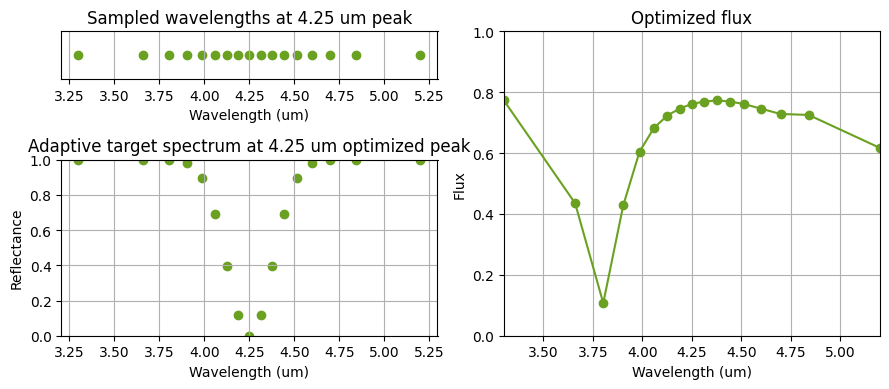

	Finished objective function evaluation.
	Error value: 0.2586059385859052
Iteration 2
	Uploading batch simulation data...
	Finished batch simulation.


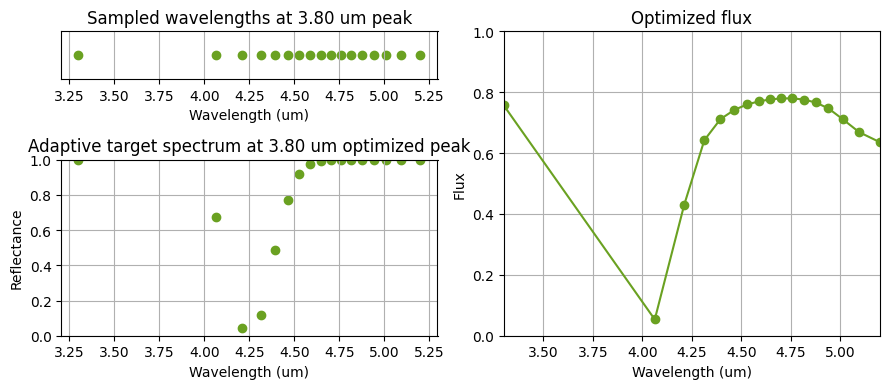

	Finished objective function evaluation.
	Error value: 0.16808014900339763
Iteration 3
	Uploading batch simulation data...
	Finished batch simulation.


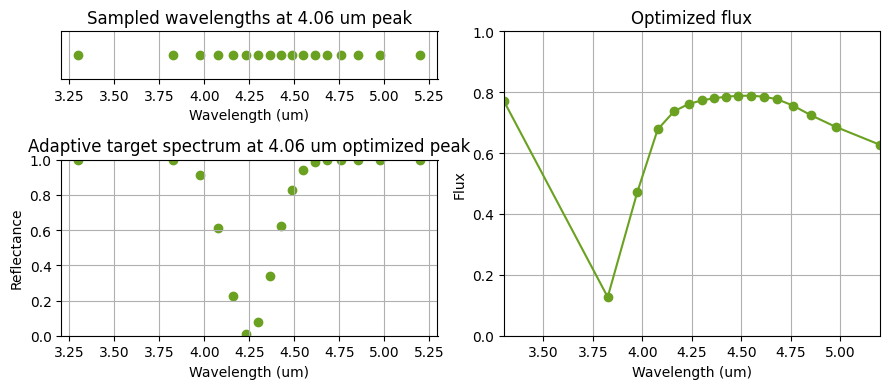

	Finished objective function evaluation.
	Error value: 0.23402430681288683
Iteration 4
	Uploading batch simulation data...
	Finished batch simulation.


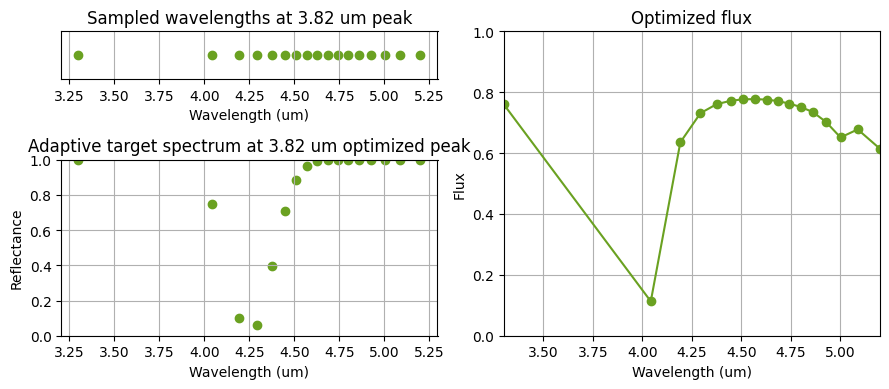

	Finished objective function evaluation.
	Error value: 0.19577506565171007
Iteration 5
	Uploading batch simulation data...
	Finished batch simulation.


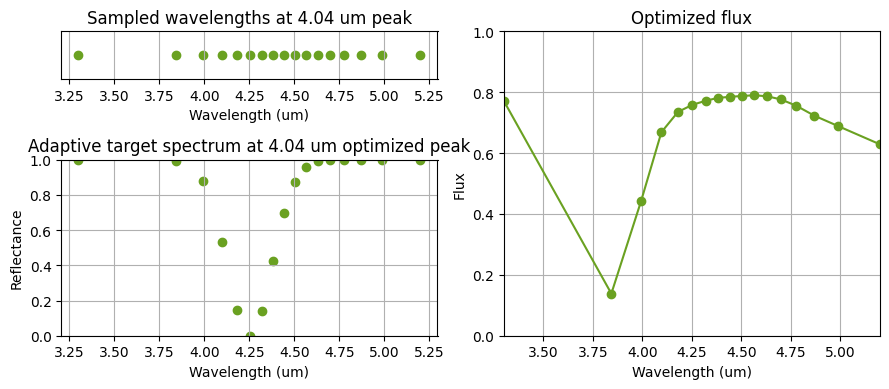

	Finished objective function evaluation.


KeyboardInterrupt: 

In [21]:
i = 0

while i < number_of_iterations:
    if retrieval == True: 
        i = iteration_num
        retrieval = False

    print(f"Iteration {i + 1}")

    # Compute the value (error) and gradient of the objective function
    val_i, grad_i = val_and_grad_fn(params_i)
    # grad_norm_i = np.linalg.norm(grad_i)

    print(f"\tError value: {val_i}")

    # Visualize the iteration results
    # plot_flux(i + 1)

    # Adjusting the step size as the optimization goes on
    step_size = val_i * step_size_fraction
    optimizer = optax.adam(learning_rate=step_size)
    optimizer_state = optimizer.init(np.concatenate(params_i))

    params_i_concatenated = np.concatenate(params_i)
    grad_i_concatenated = np.concatenate(grad_i)

    # Update the parameters: error (loss) as small as possible
    updates, optimizer_state = optimizer.update(grad_i_concatenated, optimizer_state, params_i_concatenated)
    params_i_concatenated = optax.apply_updates(params_i_concatenated, updates) # params_i is now Jax-traced

    # Restore the original shape of the parameters
    params_i = np.array(params_i_concatenated)
    params_i = np.split(params_i, np.cumsum(shape[:-1]))

    # Save the optimization history
    params_history.append(params_i)
    error_history.append(val_i)
    grad_history.append(grad_i)
    # Simulation data history is stored in sim_data_history in objective_fn

    # Save the current optimization progress in the file
    save_data(file_name, i)

    i = i + 1

## Data Visualization

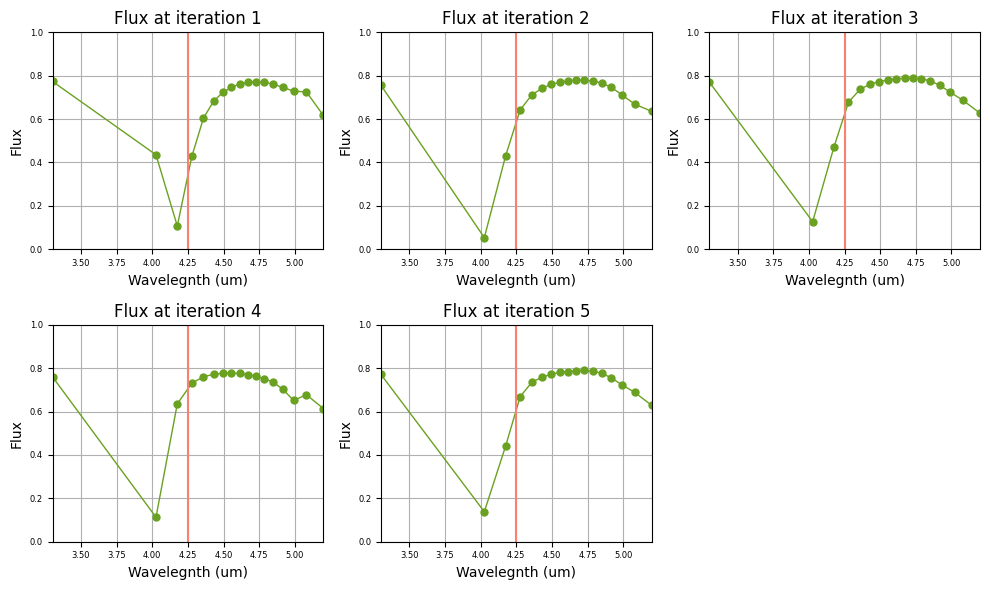

In [40]:
# Flux history

#fig, axes = plt.subplots(4, 3, figsize = (9, 12))
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

axes = axes.flatten()

for i, flux in enumerate(fluxes_history):
    # flux = [flux._value for flux in fluxes_history[i]]
    ax = axes[i]
    ax.plot(monitor_wvls, flux, marker='o', markersize=5, linewidth=1, color='#6AA121')
    ax.set_title(f'Flux at iteration {i+1}')
    ax.set_xlabel('Wavelegnth (um)')
    ax.set_ylabel('Flux')
    ax.set_xlim(wvl_range[0], wvl_range[1])
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.axvline(x=wvl0, color='#FA8072')
    ax.tick_params(axis='both', which='major', labelsize=6)

fig.delaxes(axes[-1]) # Delete the last subplot if number_of_iterations == 5
plt.tight_layout()
plt.savefig("flux_history.png")
plt.show()

In [ ]:
# Error history
plt.figure(figsize=(3, 3))
plt.plot(error_history)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.xlim((0, 10))
plt.title("Error History")
plt.show()

In [ ]:
#%%script echo skip

# Retrieve geometric parameters at the {itr}th iteration
itr = 10
wvl_points_for_checking = 101
wvls_for_checking = np.linspace(wvl_range[0], wvl_range[1], wvl_points_for_checking)
freqs_for_checking = np.flip(td.constants.C_0 / wvls_for_checking)

FLUX_MONITOR_FOR_CHECKING_NAME = 'flux_monitor_for_checking'

monitor_flux_for_checking = td.FluxMonitor(
    center=(0, 0, Lz / 2 - wvl0),
    size=(td.inf, td.inf, 0),
    freqs=freqs_for_checking,
    name=FLUX_MONITOR_FOR_CHECKING_NAME,
)

sim_for_checking = make_sim(params_history[itr-1])
sim_for_checking = sim_for_checking.updated_copy(monitors=[monitor_flux_for_checking])
sim_for_checking.plot_3d()

In [ ]:
#%%script echo skip

sim_data_for_checking = web.run(simulation=sim_for_checking, task_name=f"{itr}th_iteration", path=f"data/{itr}th_iteration.hdf5", verbose=False)

In [ ]:
#%%script echo skip

reflectance = sim_data_for_checking[FLUX_MONITOR_FOR_CHECKING_NAME].flux

plt.figure(figsize=(3, 3))
plt.plot(wvls_for_checking, reflectance, label='Reflectance')
plt.axvline(x=4.25, color='r', label='Target')
plt.xlabel('Wavelengths (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at iteration {itr}')
plt.show()